# Feature Engineering: Electric Vehicle Sales Analysis

This notebook focuses on creating meaningful features from our EV sales dataset to enhance our analysis capabilities. Based on our data cleaning and documentation findings, we'll implement several feature engineering strategies to better understand:

1. Temporal patterns in EV adoption
2. Regional market characteristics
3. Vehicle segment dynamics
4. Market penetration metrics
5. Growth and adoption indicators

In [119]:
# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_csv("../../data/processed/processed_ev_sales_by_state.csv")

# Convert date column to datetime
df["date"] = pd.to_datetime(df["date"])

# Display basic information about the dataset
print("Dataset Overview:")
print("-" * 50)
print(
    f"Time Range: {df['date'].min().strftime('%B %Y')} to {df['date'].max().strftime('%B %Y')}"
)
print(f"Number of States: {df['state'].nunique()}")
print(f"Total Records: {len(df)}")
display(df.head())

Dataset Overview:
--------------------------------------------------
Time Range: April 2021 to March 2024
Number of States: 35
Total Records: 2445


,date,state,vehicle_category,electric_vehicles_sold,total_vehicles_sold,ev_penetration,year,month,month_name,conventional_vehicles_sold,quarter
0,2021-04-01,Andaman & Nicobar Island,2-Wheelers,0,515,0.00,2021,4,Apr,515,2
1,2021-04-01,Andaman & Nicobar Island,4-Wheelers,9,168,5.36,2021,4,Apr,159,2
2,2021-04-01,Andhra Pradesh,2-Wheelers,436,63444,0.69,2021,4,Apr,63008,2
3,2021-04-01,Andhra Pradesh,4-Wheelers,26,7837,0.33,2021,4,Apr,7811,2
4,2021-04-01,Arunachal Pradesh,2-Wheelers,0,1256,0.00,2021,4,Apr,1256,2


## 1. Temporal Feature Engineering

Based on our data analysis, we'll create the following time-based features:
1. Year, Month, Quarter for seasonal analysis
2. Time-based indices for trend analysis
3. Rolling statistics for market momentum
4. Year-over-Year growth metrics
5. Seasonal indicators for cyclical patterns

In [142]:
# Create temporal features
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["quarter"] = df["date"].dt.quarter
df["month_name"] = df["date"].dt.strftime("%B")
df["year_month"] = df["date"].dt.strftime("%Y-%m")

# Create time index (months since start)
df["months_from_start"] = (df["date"].dt.year - df["date"].dt.year.min()) * 12 + (
    df["date"].dt.month - df["date"].dt.month.min()
)

# Calculate rolling statistics (3-month window)
# First, sort the data
df_sorted = df.sort_values(["state", "vehicle_category", "date"])

# Calculate rolling means for each state and vehicle category
df["rolling_mean_ev"] = df_sorted.groupby(["state", "vehicle_category"])[
    "electric_vehicles_sold"
].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Calculate growth rates
df["ev_growth_rate"] = (
    df_sorted.groupby(["state", "vehicle_category"])["electric_vehicles_sold"]
    .transform(lambda x: x.pct_change())
    .replace([np.inf, -np.inf], np.nan)  # Step 2: Handle inf and -inf
    .fillna(0)                           # Step 3: Replace NaN with 0
    .round(2)                            # Step 4: Round to 2 decimal places
)


# Create seasonal indicators (quarter and month dummies)
df["is_q4"] = (df["quarter"] == 4).astype(int)  # Year-end quarter
df["is_march"] = (df["month"] == 3).astype(int)  # Financial year end in India

# Display the new features
print("\nTemporal Features Overview:")
print("-" * 50)
display(
    df[
        [
            "date",
            "year",
            "month",
            "quarter",
            "months_from_start",
            "rolling_mean_ev",
            "ev_growth_rate",
            "is_q4",
            "is_march",
        ]
    ]
)


Temporal Features Overview:
--------------------------------------------------


,date,year,month,quarter,months_from_start,rolling_mean_ev,ev_growth_rate,is_q4,is_march
0,2021-04-01,2021,4,2,3,0.000000,0.00,0,0
1,2021-04-01,2021,4,2,3,9.000000,0.00,0,0
2,2021-04-01,2021,4,2,3,436.000000,0.00,0,0
3,2021-04-01,2021,4,2,3,26.000000,0.00,0,0
4,2021-04-01,2021,4,2,3,0.000000,0.00,0,0
...,...,...,...,...,...,...,...,...,...
2440,2024-03-01,2024,3,1,38,394.000000,-0.01,0,1
2441,2024-03-01,2024,3,1,38,515.666667,-0.01,0,1
2442,2024-03-01,2024,3,1,38,53.333333,-0.15,0,1
2443,2024-03-01,2024,3,1,38,1712.000000,0.61,0,1


## 2. Market Penetration Features

Based on our analysis of the non-normal distribution and growth patterns, we'll create:
1. EV penetration rates
2. Normalized market shares
3. Relative market position metrics
4. Growth stage indicators
5. Market concentration metrics

In [143]:
# Calculate basic penetration rate
df["ev_penetration"] = (
    df["electric_vehicles_sold"] / df["total_vehicles_sold"] * 100
).round(2)

# Calculate market shares
df["national_market_share"] = (
    df.groupby("date")["electric_vehicles_sold"]
    .transform(lambda x: x / x.sum() * 100)
    .round(2)
)

# Calculate state-wise market position
df["state_rank"] = df.groupby(["date", "vehicle_category"])[
    "electric_vehicles_sold"
].transform(lambda x: x.rank(method="dense", ascending=False))

# Create growth stage indicators using penetration rate quartiles
df["growth_stage"] = pd.qcut(
    df["ev_penetration"], q=4, labels=["Early", "Developing", "Maturing", "Advanced"]
)

# Calculate market concentration (normalized relative to max)
df["market_concentration"] = df.groupby(["date", "vehicle_category"])[
    "electric_vehicles_sold"
].transform(lambda x: x / x.max())

# Calculate relative growth (compared to national average)
national_avg_growth = df.groupby("date")["ev_growth_rate"].transform("mean")
df["relative_growth"] = (df["ev_growth_rate"] - national_avg_growth).fillna(0).round(2)

# Display the new features
print("\nMarket Penetration Features Overview:")
print("-" * 50)
display(
    df[
        [
            "state",
            "date",
            "ev_penetration",
            "national_market_share",
            "state_rank",
            "growth_stage",
            "market_concentration",
            "relative_growth",
        ]
    ].head(10)
)


Market Penetration Features Overview:
--------------------------------------------------


,state,date,ev_penetration,national_market_share,state_rank,growth_stage,market_concentration,relative_growth
0,Andaman and Nicobar Islands,2021-04-01,0.00,0.00,24.0,Early,0.000000,0.0
1,Andaman and Nicobar Islands,2021-04-01,5.36,0.14,11.0,Advanced,0.068182,0.0
2,Andhra Pradesh,2021-04-01,0.69,6.90,3.0,Developing,0.281472,0.0
3,Andhra Pradesh,2021-04-01,0.33,0.41,7.0,Developing,0.196970,0.0
4,Arunachal Pradesh,2021-04-01,0.00,0.00,24.0,Early,0.000000,0.0
5,Arunachal Pradesh,2021-04-01,0.00,0.00,18.0,Early,0.000000,0.0
6,Assam,2021-04-01,0.02,0.11,20.0,Early,0.004519,0.0
7,Assam,2021-04-01,0.00,0.00,18.0,Early,0.000000,0.0
8,Bihar,2021-04-01,0.06,0.74,14.0,Early,0.030342,0.0
9,Bihar,2021-04-01,0.07,0.06,14.0,Early,0.030303,0.0


## 3. Regional Features

To capture the geographical aspects of EV adoption, we'll create:
1. Regional groupings
2. State-level benchmarking metrics
3. Regional market maturity indicators
4. Geographic concentration indices
5. State-wise adoption velocity metrics

In [144]:
# Show distinct states
print("\n" + 20 * "=")
print("Top 10 Distinct states:")
print(20 * "=")
unique_states = df["state"].unique()
print("\n".join([f"- {state}" for state in sorted(unique_states)]))

# Show the distinct states length
print(f"\nTotal Distinct States: {len(unique_states)}")


Top 10 Distinct states:
- Andaman and Nicobar Islands
- Andhra Pradesh
- Arunachal Pradesh
- Assam
- Bihar
- Chandigarh
- Chhattisgarh
- Dadra and Nagar Haveli and Daman and Diu
- Delhi
- Goa
- Gujarat
- Haryana
- Himachal Pradesh
- Jammu and Kashmir
- Jharkhand
- Karnataka
- Kerala
- Ladakh
- Madhya Pradesh
- Maharashtra
- Manipur
- Meghalaya
- Mizoram
- Nagaland
- Odisha
- Puducherry
- Punjab
- Rajasthan
- Sikkim
- Tamil Nadu
- Tripura
- Uttar Pradesh
- Uttarakhand
- West Bengal

Total Distinct States: 34


In [145]:
# Mapping inconsistent names to standard names
state_cleaning_map = {
    "Andaman & Nicobar": "Andaman and Nicobar Islands",
    "Andaman & Nicobar Island": "Andaman and Nicobar Islands",
    "DNH and DD": "Dadra and Nagar Haveli and Daman and Diu",
}

# Apply the map
df["state"] = df["state"].replace(state_cleaning_map)

# Recheck distinct values
unique_states = df["state"].unique()
print("\nCleaned Distinct States:")
print("\n".join([f"- {state}" for state in sorted(unique_states)]))
print(f"\nTotal Cleaned Distinct States: {len(unique_states)}")

display(df)


Cleaned Distinct States:
- Andaman and Nicobar Islands
- Andhra Pradesh
- Arunachal Pradesh
- Assam
- Bihar
- Chandigarh
- Chhattisgarh
- Dadra and Nagar Haveli and Daman and Diu
- Delhi
- Goa
- Gujarat
- Haryana
- Himachal Pradesh
- Jammu and Kashmir
- Jharkhand
- Karnataka
- Kerala
- Ladakh
- Madhya Pradesh
- Maharashtra
- Manipur
- Meghalaya
- Mizoram
- Nagaland
- Odisha
- Puducherry
- Punjab
- Rajasthan
- Sikkim
- Tamil Nadu
- Tripura
- Uttar Pradesh
- Uttarakhand
- West Bengal

Total Cleaned Distinct States: 34


,date,state,vehicle_category,electric_vehicles_sold,total_vehicles_sold,ev_penetration,year,month,month_name,conventional_vehicles_sold,...,segment_preference_ratio_capped,adoption_velocity_capped,segment_preference_ratio_log,ev_penetration_log,ev_sales_growth_rank_state,ev_sales_growth_rank_region,is_early_adopter,peak_penetration,is_at_peak,months_since_peak
0,2021-04-01,Andaman and Nicobar Islands,2-Wheelers,0,515,0.00,2021,4,April,515,...,0.00,0.000000,0.000000,0.000000,1.0,1.0,1,2.52,0,1.0
1,2021-04-01,Andaman and Nicobar Islands,4-Wheelers,9,168,5.36,2021,4,April,159,...,0.00,0.000000,0.000000,1.850028,1.0,1.0,0,5.36,1,0.0
2,2021-04-01,Andhra Pradesh,2-Wheelers,436,63444,0.69,2021,4,April,63008,...,2.09,0.000000,1.128171,0.524729,1.0,1.0,0,10.21,0,1.0
3,2021-04-01,Andhra Pradesh,4-Wheelers,26,7837,0.33,2021,4,April,7811,...,2.09,0.000000,1.128171,0.285179,1.0,1.0,0,4.67,0,1.0
4,2021-04-01,Arunachal Pradesh,2-Wheelers,0,1256,0.00,2021,4,April,1256,...,3.32,0.000000,1.463255,0.000000,1.0,1.0,1,0.15,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440,2024-03-01,Uttar Pradesh,4-Wheelers,389,34425,1.13,2024,3,March,34036,...,3.28,0.070000,1.453953,0.756122,16.0,5.0,0,1.69,0,32.0
2441,2024-03-01,Uttarakhand,2-Wheelers,579,12506,4.63,2024,3,March,11927,...,4.37,0.350000,1.680828,1.728109,25.0,8.0,0,5.47,0,20.0
2442,2024-03-01,Uttarakhand,4-Wheelers,51,4812,1.06,2024,3,March,4761,...,4.37,0.030000,1.680828,0.722706,20.0,7.0,0,1.30,0,25.0
2443,2024-03-01,West Bengal,2-Wheelers,2159,69871,3.09,2024,3,March,67712,...,0.50,1.280000,0.405465,1.408545,11.0,3.0,0,3.09,1,35.0


In [124]:
from geopy.geocoders import Nominatim
import time

# Initialize the geolocator
geolocator = Nominatim(user_agent="india-state-geocoder")


# Create a function to fetch coordinates
def get_coordinates(state_name):
    try:
        location = geolocator.geocode(f"{state_name}, India")
        if location:
            return pd.Series(
                {"latitude": location.latitude, "longitude": location.longitude}
            )
        return pd.Series({"latitude": None, "longitude": None})
    except Exception as e:
        print(f"Error for {state_name}: {e}")
        return pd.Series({"latitude": None, "longitude": None})


# Apply to unique state names and create DataFrame directly
unique_states = df["state"].dropna().drop_duplicates()
state_coords = unique_states.apply(get_coordinates)
state_coords_df = pd.DataFrame(state_coords)
state_coords_df["state"] = unique_states.values

# Merge back with original df
df = df.merge(state_coords_df, on="state", how="left")

display(df)

,date,state,vehicle_category,electric_vehicles_sold,total_vehicles_sold,ev_penetration,year,month,month_name,conventional_vehicles_sold,...,ev_growth_rate,is_q4,is_march,national_market_share,state_rank,growth_stage,market_concentration,relative_growth,latitude,longitude
0,2021-04-01,Andaman and Nicobar Islands,2-Wheelers,0,515,0.00,2021,4,April,515,...,0.00,0,0,0.00,24.0,Early,0.000000,0.0,12.611239,92.831654
1,2021-04-01,Andaman and Nicobar Islands,4-Wheelers,9,168,5.36,2021,4,April,159,...,0.00,0,0,0.14,11.0,Advanced,0.068182,0.0,12.611239,92.831654
2,2021-04-01,Andhra Pradesh,2-Wheelers,436,63444,0.69,2021,4,April,63008,...,0.00,0,0,6.90,3.0,Developing,0.281472,0.0,15.924091,80.186381
3,2021-04-01,Andhra Pradesh,4-Wheelers,26,7837,0.33,2021,4,April,7811,...,0.00,0,0,0.41,7.0,Developing,0.196970,0.0,15.924091,80.186381
4,2021-04-01,Arunachal Pradesh,2-Wheelers,0,1256,0.00,2021,4,April,1256,...,0.00,0,0,0.00,24.0,Early,0.000000,0.0,28.093770,94.592133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440,2024-03-01,Uttar Pradesh,4-Wheelers,389,34425,1.13,2024,3,March,34036,...,-0.01,0,1,0.28,9.0,Maturing,0.262483,-inf,27.130334,80.859666
2441,2024-03-01,Uttarakhand,2-Wheelers,579,12506,4.63,2024,3,March,11927,...,-0.01,0,1,0.42,19.0,Advanced,0.021711,-inf,30.041738,79.089691
2442,2024-03-01,Uttarakhand,4-Wheelers,51,4812,1.06,2024,3,March,4761,...,-0.15,0,1,0.04,20.0,Maturing,0.034413,-inf,30.041738,79.089691
2443,2024-03-01,West Bengal,2-Wheelers,2159,69871,3.09,2024,3,March,67712,...,0.61,0,1,1.56,13.0,Advanced,0.080958,-inf,22.996495,87.685588


In [146]:
df.isnull().sum()

date                                     0
state                                    0
vehicle_category                         0
electric_vehicles_sold                   0
total_vehicles_sold                      0
ev_penetration                           0
year                                     0
month                                    0
month_name                               0
conventional_vehicles_sold               0
quarter                                  0
year_month                               0
months_from_start                        0
rolling_mean_ev                          0
ev_growth_rate                           0
is_q4                                    0
is_march                                 0
national_market_share                    0
state_rank                               0
growth_stage                             0
market_concentration                     0
relative_growth                          0
latitude                                 0
longitude  

In [147]:
def analyze_missing_geographic_data(df, lat_col="latitude", lon_col="longitude"):
    """
    Analyzes missing geographic data in a dataframe and returns detailed information.

    Parameters:
    -----------
    df : pandas DataFrame
      The dataframe containing geographic coordinates
    lat_col : str, default='latitude'
      Name of the latitude column
    lon_col : str, default='longitude'
      Name of the longitude column

    Returns:
    --------
    dict
      Dictionary containing analysis results including missing records count,
      affected states, and sample records
    """
    # Find rows where both latitude and longitude are null
    missing_coords = df.loc[df[lat_col].isnull() & df[lon_col].isnull()]

    # Get unique states with missing coordinates
    affected_states = missing_coords["state"].unique()

    # Get count by state
    missing_by_state = missing_coords["state"].value_counts()

    # Sample records
    sample_records = missing_coords[["state", "date", "vehicle_category"]].head()

    # Prepare results dictionary
    results = {
        "missing_count": len(missing_coords),
        "affected_states": affected_states,
        "missing_by_state": missing_by_state,
        "sample_records": sample_records,
    }

    return results


# Analyze missing geographic data
geo_analysis = analyze_missing_geographic_data(df)

# Display the results
print(f"Number of records with missing coordinates: {geo_analysis['missing_count']}")
print("\nStates with missing coordinates:")
print(20 * "=")
print("\n".join([f"- {state}" for state in sorted(geo_analysis["affected_states"])]))

print("\nMissing coordinates by state:")
print(20 * "=")
display(geo_analysis["missing_by_state"])

print("\nSample records with missing coordinates:")
print(20 * "=")
display(geo_analysis["sample_records"])

Number of records with missing coordinates: 0

States with missing coordinates:


Missing coordinates by state:


Series([], Name: count, dtype: int64)


Sample records with missing coordinates:


,state,date,vehicle_category


## 3. Regional Features

To capture the geographical aspects of EV adoption, we'll create regional features that help us analyze patterns across different parts of India. While we've successfully retrieved geographic coordinates for most states using geopy, we encountered issues with a few key states: Delhi, Himachal Pradesh, and Kerala.

To address this gap, we'll manually add coordinates for these states based on reliable sources. These coordinates are essential for our regional analysis and for visualizing geographic patterns in EV adoption across India.

In [148]:
# Manually add missing coordinates for states with geocoding issues
missing_coords = {
    "Delhi": {"latitude": 28.7041, "longitude": 77.1025},
    "Himachal Pradesh": {"latitude": 31.1048, "longitude": 77.1734},
    "Kerala": {"latitude": 10.8505, "longitude": 76.2711},
    "Maharashtra": {"latitude": 19.7515, "longitude": 75.7139},
}

# Apply missing coordinates to the dataframe
for state, coords in missing_coords.items():
    df.loc[df["state"] == state, "latitude"] = coords["latitude"]
    df.loc[df["state"] == state, "longitude"] = coords["longitude"]

# Summary of manually updated states
print("Manually added coordinates for the following states:")
for state in missing_coords:
    count = df[
        (df["state"] == state) & (df["latitude"] == missing_coords[state]["latitude"])
    ].shape[0]
    print(f"- {state}: {count} records updated")

display(df.isnull().sum())

Manually added coordinates for the following states:
- Delhi: 72 records updated
- Himachal Pradesh: 72 records updated
- Kerala: 72 records updated
- Maharashtra: 72 records updated


date                                     0
state                                    0
vehicle_category                         0
electric_vehicles_sold                   0
total_vehicles_sold                      0
ev_penetration                           0
year                                     0
month                                    0
month_name                               0
conventional_vehicles_sold               0
quarter                                  0
year_month                               0
months_from_start                        0
rolling_mean_ev                          0
ev_growth_rate                           0
is_q4                                    0
is_march                                 0
national_market_share                    0
state_rank                               0
growth_stage                             0
market_concentration                     0
relative_growth                          0
latitude                                 0
longitude  

In [128]:
print(f"Number of records with missing coordinates: {geo_analysis['missing_count']}")
print("\nStates with missing coordinates:")
print(20 * "=")
print("\n".join([f"- {state}" for state in sorted(geo_analysis["affected_states"])]))

print("\nMissing coordinates by state:")
print(20 * "=")
display(geo_analysis["missing_by_state"])

print("\nSample records with missing coordinates:")
print(20 * "=")
display(geo_analysis["sample_records"])

Number of records with missing coordinates: 0

States with missing coordinates:


Missing coordinates by state:


Series([], Name: count, dtype: int64)


Sample records with missing coordinates:


,state,date,vehicle_category


In [129]:
def classify_region(lat, lon):
    if lat >= 28:
        if lon >= 85:
            return "Northeast"
        elif lon >= 75:
            return "North"
        else:
            return "Northwest"
    elif 23 <= lat < 28:
        return "Central"
    elif lat < 23:
        if lon < 80:
            return "West"
        else:
            return "South"

In [130]:
df["region"] = df.apply(
    lambda row: classify_region(row["latitude"], row["longitude"]), axis=1
)


# Display the updated DataFrame with regions
print("\nUpdated DataFrame with Regions:")
display(df)

display(df["region"].value_counts())


Updated DataFrame with Regions:


,date,state,vehicle_category,electric_vehicles_sold,total_vehicles_sold,ev_penetration,year,month,month_name,conventional_vehicles_sold,...,is_q4,is_march,national_market_share,state_rank,growth_stage,market_concentration,relative_growth,latitude,longitude,region
0,2021-04-01,Andaman and Nicobar Islands,2-Wheelers,0,515,0.00,2021,4,April,515,...,0,0,0.00,24.0,Early,0.000000,0.0,12.611239,92.831654,South
1,2021-04-01,Andaman and Nicobar Islands,4-Wheelers,9,168,5.36,2021,4,April,159,...,0,0,0.14,11.0,Advanced,0.068182,0.0,12.611239,92.831654,South
2,2021-04-01,Andhra Pradesh,2-Wheelers,436,63444,0.69,2021,4,April,63008,...,0,0,6.90,3.0,Developing,0.281472,0.0,15.924091,80.186381,South
3,2021-04-01,Andhra Pradesh,4-Wheelers,26,7837,0.33,2021,4,April,7811,...,0,0,0.41,7.0,Developing,0.196970,0.0,15.924091,80.186381,South
4,2021-04-01,Arunachal Pradesh,2-Wheelers,0,1256,0.00,2021,4,April,1256,...,0,0,0.00,24.0,Early,0.000000,0.0,28.093770,94.592133,Northeast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440,2024-03-01,Uttar Pradesh,4-Wheelers,389,34425,1.13,2024,3,March,34036,...,0,1,0.28,9.0,Maturing,0.262483,-inf,27.130334,80.859666,Central
2441,2024-03-01,Uttarakhand,2-Wheelers,579,12506,4.63,2024,3,March,11927,...,0,1,0.42,19.0,Advanced,0.021711,-inf,30.041738,79.089691,North
2442,2024-03-01,Uttarakhand,4-Wheelers,51,4812,1.06,2024,3,March,4761,...,0,1,0.04,20.0,Maturing,0.034413,-inf,30.041738,79.089691,North
2443,2024-03-01,West Bengal,2-Wheelers,2159,69871,3.09,2024,3,March,67712,...,0,1,1.56,13.0,Advanced,0.080958,-inf,22.996495,87.685588,South


region
Central      864
North        576
West         576
South        357
Northeast     72
Name: count, dtype: int64

In [131]:
df.head()

,date,state,vehicle_category,electric_vehicles_sold,total_vehicles_sold,ev_penetration,year,month,month_name,conventional_vehicles_sold,...,is_q4,is_march,national_market_share,state_rank,growth_stage,market_concentration,relative_growth,latitude,longitude,region
0,2021-04-01,Andaman and Nicobar Islands,2-Wheelers,0,515,0.00,2021,4,April,515,...,0,0,0.00,24.0,Early,0.000000,0.0,12.611239,92.831654,South
1,2021-04-01,Andaman and Nicobar Islands,4-Wheelers,9,168,5.36,2021,4,April,159,...,0,0,0.14,11.0,Advanced,0.068182,0.0,12.611239,92.831654,South
2,2021-04-01,Andhra Pradesh,2-Wheelers,436,63444,0.69,2021,4,April,63008,...,0,0,6.90,3.0,Developing,0.281472,0.0,15.924091,80.186381,South
3,2021-04-01,Andhra Pradesh,4-Wheelers,26,7837,0.33,2021,4,April,7811,...,0,0,0.41,7.0,Developing,0.196970,0.0,15.924091,80.186381,South
4,2021-04-01,Arunachal Pradesh,2-Wheelers,0,1256,0.00,2021,4,April,1256,...,0,0,0.00,24.0,Early,0.000000,0.0,28.093770,94.592133,Northeast


In [149]:
# Calculate regional metrics
df["regional_avg_penetration"] = df.groupby(["region", "date"])[
    "ev_penetration"
].transform("mean")
# Calculate state-to-region ratio (safely handling division by zero)
df["state_to_region_ratio"] = df.apply(
    lambda row: (
        row["ev_penetration"] / row["regional_avg_penetration"]
        if row["regional_avg_penetration"] > 0
        else 0
    ),
    axis=1,
).round(2)

# Calculate state rankings within regions
df["regional_rank"] = df.groupby(["region", "date", "vehicle_category"])[
    "electric_vehicles_sold"
].transform(lambda x: x.rank(method="dense", ascending=False))

# Calculate regional market maturity score (0-100)
df["market_maturity_score"] = (
    df.groupby(["region", "date"])["ev_penetration"]
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()) * 100)
    .fillna(0)
    .round(2)
)

# Calculate adoption velocity (change in penetration rate)
df["adoption_velocity"] = (
    df.groupby(["state", "vehicle_category"])["ev_penetration"]
    .transform(lambda x: x.diff())
    .fillna(0)
    .round(2)
)

# Display the new features
print("\nRegional Features Overview:")
print("-" * 50)

regional_metrix = df[
    [
        "state",
        "region",
        "date",
        "regional_avg_penetration",
        "state_to_region_ratio",
        "regional_rank",
        "market_maturity_score",
        "adoption_velocity",
    ]
]
display(regional_metrix.head(10))

display(regional_metrix.isnull().sum())

# Calculate summary statistics by region
regional_summary = (
    df.groupby("region")
    .agg(
        {
            "ev_penetration": ["mean", "std"],
            "electric_vehicles_sold": "sum",
            "market_maturity_score": "mean",
        }
    )
    .round(2)
)


print("\nRegional Summary Statistics:")
print("-" * 50)
display(regional_summary)


Regional Features Overview:
--------------------------------------------------


,state,region,date,regional_avg_penetration,state_to_region_ratio,regional_rank,market_maturity_score,adoption_velocity
0,Andaman and Nicobar Islands,South,2021-04-01,0.767000,0.00,5.0,0.00,0.0
1,Andaman and Nicobar Islands,South,2021-04-01,0.767000,6.99,3.0,100.00,0.0
2,Andhra Pradesh,South,2021-04-01,0.767000,0.90,1.0,12.87,0.0
3,Andhra Pradesh,South,2021-04-01,0.767000,0.43,1.0,6.16,0.0
4,Arunachal Pradesh,Northeast,2021-04-01,0.000000,0.00,1.0,0.00,0.0
5,Arunachal Pradesh,Northeast,2021-04-01,0.000000,0.00,1.0,0.00,0.0
6,Assam,Central,2021-04-01,0.092083,0.22,6.0,2.99,0.0
7,Assam,Central,2021-04-01,0.092083,0.00,6.0,0.00,0.0
8,Bihar,Central,2021-04-01,0.092083,0.65,5.0,8.96,0.0
9,Bihar,Central,2021-04-01,0.092083,0.76,2.0,10.45,0.0


state                       0
region                      0
date                        0
regional_avg_penetration    0
state_to_region_ratio       0
regional_rank               0
market_maturity_score       0
adoption_velocity           0
dtype: int64


Regional Summary Statistics:
--------------------------------------------------


ev_penetration        electric_vehicles_sold market_maturity_score
                    mean    std                    sum                  mean
region                                                                      
Central             0.74   1.29                 381837                 14.04
North               2.27   4.25                 190982                 21.97
Northeast           0.04   0.10                     33                 18.06
South               1.97   2.16                 240133                 35.02
West                4.83  18.98                1253126                 31.65

In [165]:
# Calculate regional market growth metrics

# Find average monthly growth rate by region
region_growth = df.groupby(["region", "date"])["ev_growth_rate"].mean().reset_index()
region_growth = region_growth.rename(columns={"ev_growth_rate": "regional_growth_rate"})

# Check if 'regional_growth_rate' already exists in df and drop it if it does
if "regional_growth_rate" in df.columns:
    df = df.drop(columns=["regional_growth_rate"])

# Merge back to the main dataframe
df = df.merge(region_growth, on=["region", "date"], how="left")

# Calculate growth difference from regional average
df["growth_vs_region"] = (df["ev_growth_rate"] - df["regional_growth_rate"]).fillna(0).round(2)

# Display regional growth metrics
print("Regional Growth Metrics:")
print("-" * 50)
display(
    df[
        [
            "state",
            "region",
            "date",
            "ev_growth_rate",
            "regional_growth_rate",
            "growth_vs_region",
        ]
    ].head(10)
)
display(
    df[
        [
            "state",
            "region",
            "date",
            "ev_growth_rate",
            "regional_growth_rate",
            "growth_vs_region",
        ]
    ]
    .isnull()
    .sum()
)
display(
    df[
        [
            "state",
            "region",
            "date",
            "ev_growth_rate",
            "regional_growth_rate",
            "growth_vs_region",
        ]
    ].count()
)

Regional Growth Metrics:
--------------------------------------------------


,state,region,date,ev_growth_rate,regional_growth_rate,growth_vs_region
0,Andaman and Nicobar Islands,South,2021-04-01,0.0,0.0,0.0
1,Andaman and Nicobar Islands,South,2021-04-01,0.0,0.0,0.0
2,Andhra Pradesh,South,2021-04-01,0.0,0.0,0.0
3,Andhra Pradesh,South,2021-04-01,0.0,0.0,0.0
4,Arunachal Pradesh,Northeast,2021-04-01,0.0,0.0,0.0
5,Arunachal Pradesh,Northeast,2021-04-01,0.0,0.0,0.0
6,Assam,Central,2021-04-01,0.0,0.0,0.0
7,Assam,Central,2021-04-01,0.0,0.0,0.0
8,Bihar,Central,2021-04-01,0.0,0.0,0.0
9,Bihar,Central,2021-04-01,0.0,0.0,0.0


state                   0
region                  0
date                    0
ev_growth_rate          0
regional_growth_rate    0
growth_vs_region        0
dtype: int64

state                   2445
region                  2445
date                    2445
ev_growth_rate          2445
regional_growth_rate    2445
growth_vs_region        2445
dtype: int64

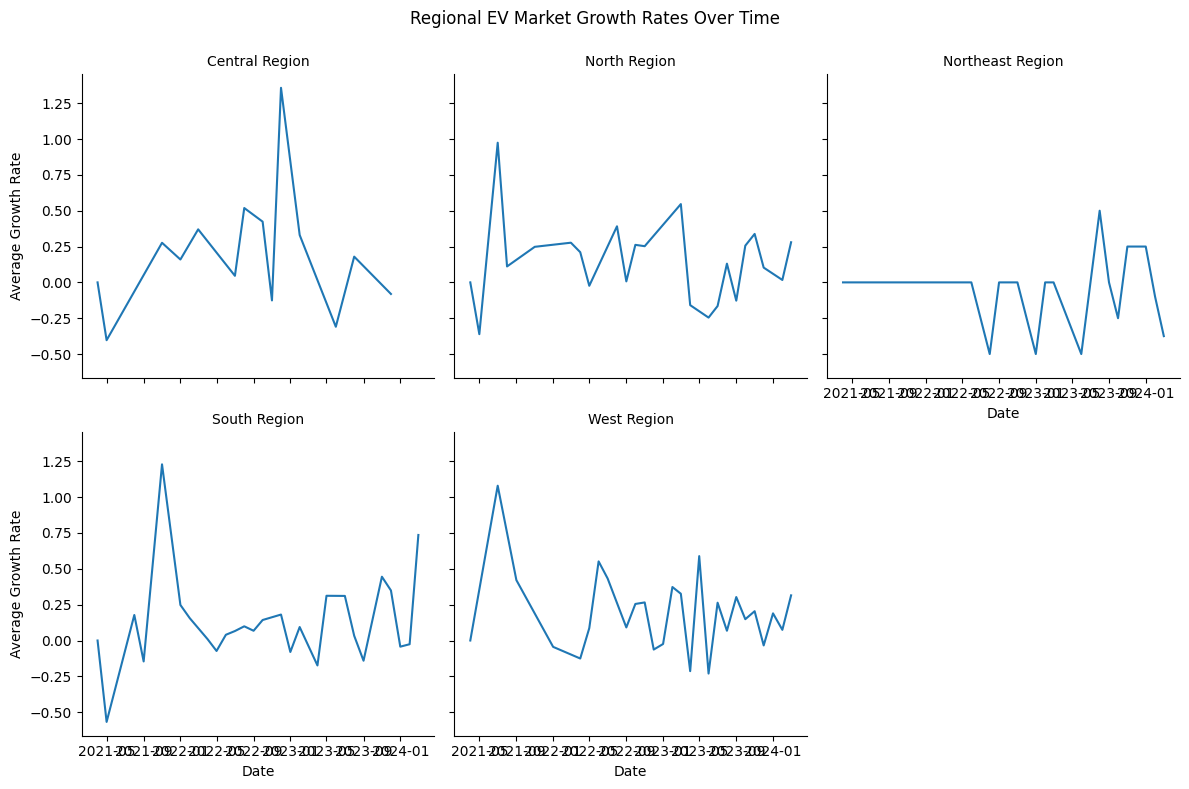

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(region_growth, col="region", col_wrap=3, height=4, sharey=True)
g.map(sns.lineplot, "date", "regional_growth_rate")
g.set_titles("{col_name} Region")
g.set_axis_labels("Date", "Average Growth Rate")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Regional EV Market Growth Rates Over Time")
plt.show()


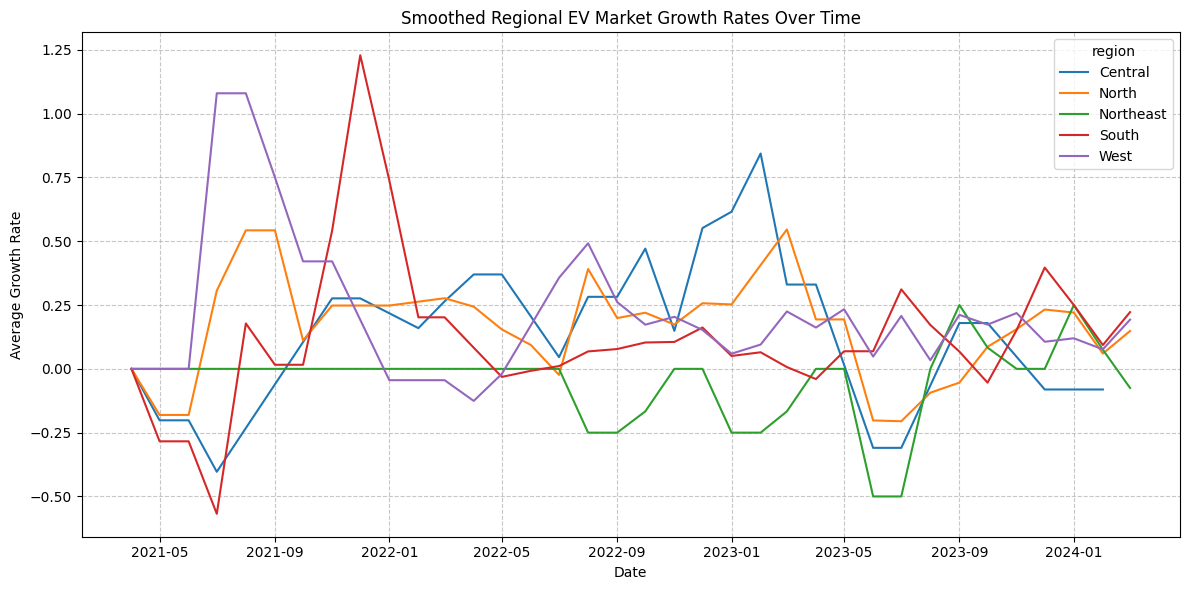

In [153]:
# Apply a rolling average (3-month window)
region_growth["smoothed_rate"] = (
    region_growth.groupby("region")["regional_growth_rate"]
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=region_growth, x="date", y="smoothed_rate", hue="region")
plt.title("Smoothed Regional EV Market Growth Rates Over Time")
plt.ylabel("Average Growth Rate")
plt.xlabel("Date")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

States by Region:

Central:
------------------------------
- Assam
- Bihar
- Jharkhand
- Madhya Pradesh
- Manipur
- Meghalaya
- Mizoram
- Nagaland
- Rajasthan
- Sikkim
- Tripura
- Uttar Pradesh

North:
------------------------------
- Chandigarh
- Delhi
- Haryana
- Himachal Pradesh
- Jammu and Kashmir
- Ladakh
- Punjab
- Uttarakhand

Northeast:
------------------------------
- Arunachal Pradesh

South:
------------------------------
- Andaman and Nicobar Islands
- Andhra Pradesh
- Chhattisgarh
- Odisha
- West Bengal

West:
------------------------------
- Dadra and Nagar Haveli and Daman and Diu
- Goa
- Gujarat
- Karnataka
- Kerala
- Maharashtra
- Puducherry
- Tamil Nadu


Count of States by Region:
Central: 12 states
North: 8 states
Northeast: 1 states
South: 5 states
West: 8 states


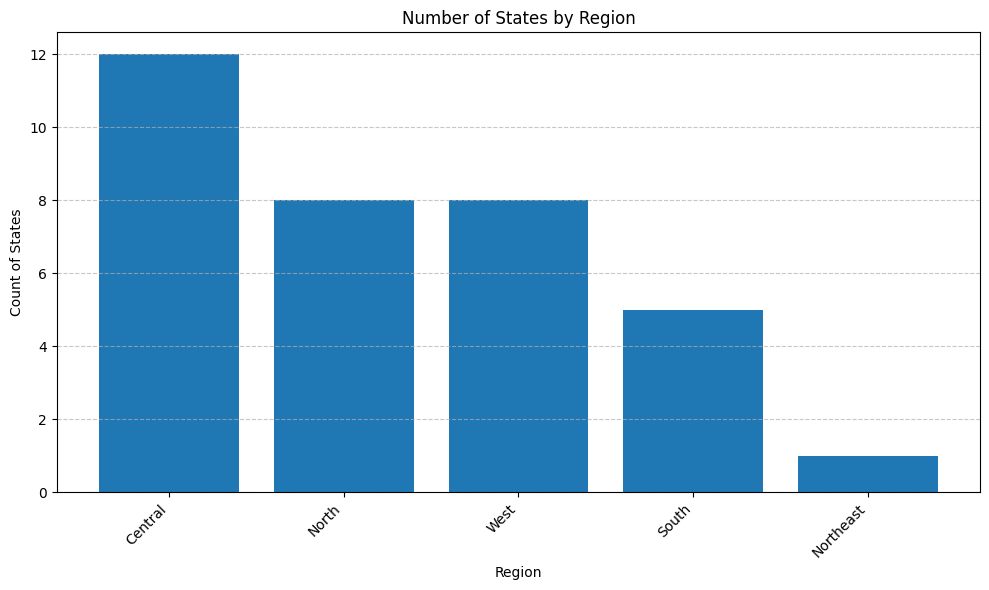

In [151]:
# Show distinct regions with states
region_states = {}

# Group states by region
for state in df["state"].unique():
    region = (
        df[df["state"] == state]["region"].iloc[0]
        if not pd.isna(df[df["state"] == state]["region"].iloc[0])
        else "Unassigned"
    )

    if region not in region_states:
        region_states[region] = []

    if state not in region_states[region]:
        region_states[region].append(state)

# Display states by region
print("States by Region:")
print("=" * 50)

for region, states in sorted(region_states.items()):
    print(f"\n{region}:")
    print("-" * 30)
    for state in sorted(states):
        print(f"- {state}")

# Count states by region
print("\n\nCount of States by Region:")
print("=" * 50)
for region, states in sorted(region_states.items()):
    print(f"{region}: {len(states)} states")

# Visualize distribution of regions
plt.figure(figsize=(10, 6))
regions_count = {region: len(states) for region, states in region_states.items()}
sorted_regions = dict(sorted(regions_count.items(), key=lambda x: x[1], reverse=True))

plt.bar(sorted_regions.keys(), sorted_regions.values())
plt.title("Number of States by Region")
plt.xlabel("Region")
plt.ylabel("Count of States")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)

## 4. Vehicle Segment Features

To analyze the differences between 2-wheeler and 4-wheeler segments, we'll create:
1. Segment-specific penetration metrics
2. Comparative adoption rates
3. Segment preference indicators
4. Cross-segment growth patterns
5. Segment market share metrics

In [161]:
# Calculate segment-specific metrics
segment_stats = (
    df.groupby(["date", "state", "vehicle_category"])
    .agg({"electric_vehicles_sold": "sum", "total_vehicles_sold": "sum"})
    .reset_index()
)

# Calculate segment penetration rates
segment_stats["segment_penetration"] = (
    segment_stats["electric_vehicles_sold"] / segment_stats["total_vehicles_sold"] * 100
).round(2)

# Pivot the data to compare segments
segment_comparison = segment_stats.pivot(
    index=["date", "state"],
    columns="vehicle_category",
    values=["segment_penetration", "electric_vehicles_sold"],
).reset_index()

# Debug: Print column structure before flattening
print("\nColumn structure before flattening:")
print(segment_comparison.columns)

# Fix column names for proper merging
segment_comparison.columns = [
    f"{col[0]}_{col[1]}".replace(" ", "_").lower() if col[1] else col[0]
    for col in segment_comparison.columns
]

# Debug: Print columns after flattening
print("\nColumns after flattening:")
print(segment_comparison.columns.tolist())

# Check if segment columns already exist in the dataframe and drop them if they do
segment_cols = [col for col in segment_comparison.columns if col in df.columns and col not in ['date', 'state']]
if segment_cols:
    print(f"\nDropping existing segment columns: {segment_cols}")
    df = df.drop(columns=segment_cols)

# Merge back to main dataframe
df = df.merge(segment_comparison, on=["date", "state"])

# Now verify we have the correct columns
print("\nColumns in final dataframe:")
print([col for col in df.columns if "segment" in col])

# Calculate segment preference ratio (2-wheeler vs 4-wheeler)
df["segment_preference_ratio"] = (
    (df["segment_penetration_2-wheelers"] / df["segment_penetration_4-wheelers"])
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)  # Handle division by zero
    .round(2)
)

# Calculate segment dominance indicator
df["dominant_segment"] = np.where(
    df["segment_preference_ratio"] > 1, "2-Wheelers", "4-Wheelers"
)

# Calculate segment growth comparison
df["segment_growth_diff"] = (
    (
        df.groupby("state")["segment_preference_ratio"].transform(
            lambda x: x.pct_change()
        )
    )
    .fillna(0)
    .round(4)
)

# Display the new features
print("\nVehicle Segment Features Overview:")
print("-" * 50)
display(
    df[
        [
            "state",
            "date",
            "segment_penetration_2-wheelers",
            "segment_penetration_4-wheelers",
            "segment_preference_ratio",
            "dominant_segment",
            "segment_growth_diff",
        ]
    ].head(10)
)

# Calculate summary statistics by segment
segment_summary = (
    df.groupby("vehicle_category")
    .agg(
        {
            "ev_penetration": ["mean", "std"],
            "electric_vehicles_sold": "sum",
            "market_maturity_score": "mean",
        }
    )
    .round(2)
)

print("\nSegment Summary Statistics:")
print("-" * 50)
display(segment_summary)


Column structure before flattening:
MultiIndex([(                  'date',           ''),
            (                 'state',           ''),
            (   'segment_penetration', '2-Wheelers'),
            (   'segment_penetration', '4-Wheelers'),
            ('electric_vehicles_sold', '2-Wheelers'),
            ('electric_vehicles_sold', '4-Wheelers')],
           names=[None, 'vehicle_category'])

Columns after flattening:
['date', 'state', 'segment_penetration_2-wheelers', 'segment_penetration_4-wheelers', 'electric_vehicles_sold_2-wheelers', 'electric_vehicles_sold_4-wheelers']

Dropping existing segment columns: ['segment_penetration_2-wheelers', 'segment_penetration_4-wheelers', 'electric_vehicles_sold_2-wheelers', 'electric_vehicles_sold_4-wheelers']

Columns in final dataframe:
['segment_penetration_2-wheelers_x', 'segment_penetration_4-wheelers_x', 'segment_preference_ratio', 'dominant_segment', 'segment_growth_diff', 'is_missing_segment_preference_ratio', 'is_missing_seg

,state,date,segment_penetration_2-wheelers,segment_penetration_4-wheelers,segment_preference_ratio,dominant_segment,segment_growth_diff
0,Andaman and Nicobar Islands,2021-04-01,0.00,5.36,0.00,4-Wheelers,0.0
1,Andaman and Nicobar Islands,2021-04-01,0.00,5.36,0.00,4-Wheelers,0.0
2,Andhra Pradesh,2021-04-01,0.69,0.33,2.09,2-Wheelers,0.0
3,Andhra Pradesh,2021-04-01,0.69,0.33,2.09,2-Wheelers,0.0
4,Arunachal Pradesh,2021-04-01,0.00,0.00,0.00,4-Wheelers,0.0
5,Arunachal Pradesh,2021-04-01,0.00,0.00,0.00,4-Wheelers,0.0
6,Assam,2021-04-01,0.02,0.00,0.00,4-Wheelers,0.0
7,Assam,2021-04-01,0.02,0.00,0.00,4-Wheelers,0.0
8,Bihar,2021-04-01,0.06,0.07,0.86,4-Wheelers,0.0
9,Bihar,2021-04-01,0.06,0.07,0.86,4-Wheelers,0.0



Segment Summary Statistics:
--------------------------------------------------


ev_penetration        electric_vehicles_sold  \
                           mean    std                    sum   
vehicle_category                                                
2-Wheelers                 3.12   4.37                1913168   
4-Wheelers                 1.32  12.85                 152943   

                 market_maturity_score  
                                  mean  
vehicle_category                        
2-Wheelers                       34.52  
4-Wheelers                       11.95

## 5. Feature Validation and Export

Let's validate our engineered features and prepare the final dataset for analysis:
1. Check for missing values in new features
2. Validate feature distributions
3. Examine feature correlations
4. Handle any anomalies
5. Export the enhanced dataset

In [136]:
# Check for missing values in all features
print("Missing Values Check:")
print("-" * 50)
missing_values = df.isnull().sum()
print("Features with missing values:")
display(missing_values[missing_values > 0])

# Basic statistics for numerical features
print("\nNumerical Feature Statistics:")
print("-" * 50)
numerical_features = df.select_dtypes(include=[np.number]).columns
display(df[numerical_features].describe().round(2))

# Correlation analysis for key features
key_features = [
    "ev_penetration",
    "national_market_share",
    "market_maturity_score",
    "adoption_velocity",
    "segment_preference_ratio",
    "ev_growth_rate",
]

correlation_matrix = df[key_features].corr().round(2)
print("\nFeature Correlation Matrix:")
print("-" * 50)
display(correlation_matrix)

# Handle any infinite values (only for numeric columns)
numeric_df = df.select_dtypes(include=[np.number])
inf_columns = numeric_df.columns[np.isinf(numeric_df).any()]
if len(inf_columns) > 0:
    print("\nHandling infinite values in:", inf_columns)
    df[inf_columns] = df[inf_columns].replace([np.inf, -np.inf], np.nan)

# Create final feature list
final_features = [
    # Temporal features
    "date",
    "year",
    "month",
    "quarter",
    "months_from_start",
    "rolling_mean_ev",
    "ev_growth_rate",
    # Market penetration features
    "ev_penetration",
    "national_market_share",
    "state_rank",
    "growth_stage",
    "market_concentration",
    # Regional features
    "region",
    "regional_avg_penetration",
    "state_to_region_ratio",
    "regional_rank",
    "market_maturity_score",
    "adoption_velocity",
    # Segment features
    "segment_penetration_2-wheelers",
    "segment_penetration_4-wheelers",
    "segment_preference_ratio",
    "dominant_segment",
    "segment_growth_diff",
    # Original features
    "state",
    "vehicle_category",
    "electric_vehicles_sold",
    "total_vehicles_sold",
]

# Prepare final dataset
final_df = df[final_features].copy()

# Export the enhanced dataset
output_path = "../../data/processed/ev_sales_enhanced.csv"
final_df.to_csv(output_path, index=False)

print(f"\nEnhanced dataset exported to: {output_path}")
print(f"Final shape: {final_df.shape}")
print(f"Total features: {len(final_features)}")

# Display sample of final dataset
print("\nSample of Enhanced Dataset:")
print("-" * 50)
display(final_df.head())

Missing Values Check:
--------------------------------------------------
Features with missing values:


growth_vs_region                      85
segment_penetration_4-wheelers         1
electric_vehicles_sold_4-wheelers      1
segment_preference_ratio             327
segment_growth_diff                  581
dtype: int64


Numerical Feature Statistics:
--------------------------------------------------


d:\anaconda3\envs\data-analysis\Lib\site-packages\numpy\lib\_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
d:\anaconda3\envs\data-analysis\Lib\site-packages\numpy\lib\_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
d:\anaconda3\envs\data-analysis\Lib\site-packages\numpy\lib\_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,electric_vehicles_sold,total_vehicles_sold,ev_penetration,year,month,conventional_vehicles_sold,quarter,months_from_start,rolling_mean_ev,ev_growth_rate,...,market_maturity_score,adoption_velocity,regional_growth_rate,growth_vs_region,segment_penetration_2-wheelers,segment_penetration_4-wheelers,electric_vehicles_sold_2-wheelers,electric_vehicles_sold_4-wheelers,segment_preference_ratio,segment_growth_diff
count,2445.00,2445.00,2445.00,2445.00,2445.00,2445.00,2445.00,2445.00,2445.00,2445.00,...,2445.00,2445.00,2445.00,2360.00,2445.00,2444.00,2445.00,2444.00,2118.00,1864.00
mean,845.04,23402.97,2.22,2022.25,6.50,22557.93,2.50,20.49,796.34,inf,...,23.24,0.12,inf,-inf,3.12,1.32,1564.96,125.16,inf,inf
std,2185.17,38353.27,9.63,0.92,3.45,36883.27,1.12,10.38,2021.67,NaN,...,29.27,12.88,NaN,NaN,4.37,12.84,2906.59,254.23,NaN,NaN
min,0.00,1.00,0.00,2021.00,1.00,-570.00,1.00,3.00,0.00,-1.00,...,0.00,-441.99,-0.57,-inf,0.00,0.00,0.00,0.00,0.00,-1.00
25%,2.00,1158.00,0.09,2022.00,4.00,1141.00,2.00,12.00,2.33,-0.10,...,1.12,-0.09,0.07,NaN,0.33,0.03,7.00,1.00,2.12,0.00
50%,54.00,6098.00,0.82,2022.00,7.00,5997.00,3.00,20.00,51.33,0.00,...,11.84,0.00,0.37,-0.40,1.56,0.46,282.00,16.00,3.69,0.00
75%,534.00,29396.00,2.49,2023.00,10.00,28533.00,4.00,29.00,529.67,0.33,...,31.08,0.30,NaN,0.00,4.51,1.19,1787.00,112.00,8.25,0.03
max,26668.00,387983.00,447.56,2024.00,12.00,382656.00,4.00,38.00,19409.33,inf,...,100.00,442.23,inf,29.14,54.60,447.56,26668.00,2060.00,inf,inf



Feature Correlation Matrix:
--------------------------------------------------


,ev_penetration,national_market_share,market_maturity_score,adoption_velocity,segment_preference_ratio,ev_growth_rate
ev_penetration,1.00,0.16,0.29,0.67,-0.04,-0.00
national_market_share,0.16,1.00,0.54,0.01,-0.06,0.02
market_maturity_score,0.29,0.54,1.00,0.07,-0.10,0.03
adoption_velocity,0.67,0.01,0.07,1.00,-0.00,0.01
segment_preference_ratio,-0.04,-0.06,-0.10,-0.00,1.00,-0.01
ev_growth_rate,-0.00,0.02,0.03,0.01,-0.01,1.00



Handling infinite values in: Index(['ev_growth_rate', 'relative_growth', 'regional_growth_rate',
       'growth_vs_region', 'segment_preference_ratio', 'segment_growth_diff'],
      dtype='object')

Enhanced dataset exported to: ../../data/processed/ev_sales_enhanced.csv
Final shape: (2445, 27)
Total features: 27

Sample of Enhanced Dataset:
--------------------------------------------------


,date,year,month,quarter,months_from_start,rolling_mean_ev,ev_growth_rate,ev_penetration,national_market_share,state_rank,...,adoption_velocity,segment_penetration_2-wheelers,segment_penetration_4-wheelers,segment_preference_ratio,dominant_segment,segment_growth_diff,state,vehicle_category,electric_vehicles_sold,total_vehicles_sold
0,2021-04-01,2021,4,2,3,0.0,0.0,0.00,0.00,24.0,...,0.0,0.00,5.36,0.00,4-Wheelers,NaN,Andaman and Nicobar Islands,2-Wheelers,0,515
1,2021-04-01,2021,4,2,3,9.0,0.0,5.36,0.14,11.0,...,0.0,0.00,5.36,0.00,4-Wheelers,NaN,Andaman and Nicobar Islands,4-Wheelers,9,168
2,2021-04-01,2021,4,2,3,436.0,0.0,0.69,6.90,3.0,...,0.0,0.69,0.33,2.09,2-Wheelers,NaN,Andhra Pradesh,2-Wheelers,436,63444
3,2021-04-01,2021,4,2,3,26.0,0.0,0.33,0.41,7.0,...,0.0,0.69,0.33,2.09,2-Wheelers,0.0,Andhra Pradesh,4-Wheelers,26,7837
4,2021-04-01,2021,4,2,3,0.0,0.0,0.00,0.00,24.0,...,0.0,0.00,0.00,NaN,4-Wheelers,NaN,Arunachal Pradesh,2-Wheelers,0,1256


## 6. Post-Engineering Improvements and Additional Features

Based on our validation analysis, we'll implement several improvements:
1. Handle missing values appropriately
2. Address outliers in key metrics
3. Add additional enrichment features
4. Perform consistency checks
5. Ensure proper data types

In [162]:
# 1. Handle Missing Values

# Create flags for missing values
missing_value_columns = [
    "ev_growth_rate",
    "segment_preference_ratio",
    "segment_growth_diff",
    "regional_avg_penetration",
    "adoption_velocity",
]

for col in missing_value_columns:
    flag_col = f"is_missing_{col}"
    df[flag_col] = df[col].isna().astype(int)

# Fill missing values with appropriate strategies
df["ev_growth_rate"] = df.groupby(["state", "vehicle_category"])[
    "ev_growth_rate"
].fillna(method="ffill")
df["segment_growth_diff"] = df.groupby("state")["segment_growth_diff"].fillna(
    method="ffill"
)
df["segment_preference_ratio"] = df.groupby("state")["segment_preference_ratio"].fillna(
    df["segment_preference_ratio"].median()
)
df["regional_avg_penetration"] = df.groupby("region")[
    "regional_avg_penetration"
].fillna(method="ffill")
df["adoption_velocity"] = df.groupby(["state", "vehicle_category"])[
    "adoption_velocity"
].fillna(0)


# 2. Handle Outliers
def cap_outliers(series, n_std=3):
    mean = series.mean()
    std = series.std()
    lower_bound = mean - n_std * std
    upper_bound = mean + n_std * std
    return series.clip(lower_bound, upper_bound)


# Cap extreme values in key metrics
df["segment_preference_ratio_capped"] = df.groupby("state")[
    "segment_preference_ratio"
].transform(cap_outliers)
df["adoption_velocity_capped"] = df.groupby(["state", "vehicle_category"])[
    "adoption_velocity"
].transform(cap_outliers)

# Create log-scaled versions of highly skewed features
df["segment_preference_ratio_log"] = np.log1p(df["segment_preference_ratio"])
df["ev_penetration_log"] = np.log1p(df["ev_penetration"])

print("Missing Value Handling Summary:")
print("-" * 50)
print("\nMissing values after handling:")
display(df[missing_value_columns].isnull().sum())

print("\nOutlier Handling Summary:")
print("-" * 50)
print("\nOriginal vs Capped Statistics:")
for col in ["segment_preference_ratio", "adoption_velocity"]:
    print(f"\n{col}:")
    print(f"Original - min: {df[col].min():.2f}, max: {df[col].max():.2f}")
    print(
        f"Capped   - min: {df[col+'_capped'].min():.2f}, max: {df[col+'_capped'].max():.2f}"
    )

Missing Value Handling Summary:
--------------------------------------------------

Missing values after handling:


C:\Users\sadiq\AppData\Local\Temp\ipykernel_15484\779830078.py:19: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  ].fillna(method="ffill")
C:\Users\sadiq\AppData\Local\Temp\ipykernel_15484\779830078.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ].fillna(method="ffill")
C:\Users\sadiq\AppData\Local\Temp\ipykernel_15484\779830078.py:20: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df["segment_growth_diff"] = df.groupby("state")["segment_growth_diff"].fillna(
C:\Users\sadiq\AppData\Local\Temp\ipykernel_15484\779830078.py:20: Futu

ev_growth_rate              0
segment_preference_ratio    0
segment_growth_diff         0
regional_avg_penetration    0
adoption_velocity           0
dtype: int64


Outlier Handling Summary:
--------------------------------------------------

Original vs Capped Statistics:

segment_preference_ratio:
Original - min: 0.00, max: 176.00
Capped   - min: 0.00, max: 137.41

adoption_velocity:
Original - min: -441.99, max: 442.23
Capped   - min: -316.90, max: 317.22


In [163]:
# 3. Additional Enrichment Features

# Calculate EV sales growth rank per state and region
df["ev_sales_growth_rank_state"] = df.groupby(["date", "vehicle_category"])[
    "ev_growth_rate"
].transform(lambda x: x.rank(method="dense", ascending=False))

df["ev_sales_growth_rank_region"] = df.groupby(["date", "region", "vehicle_category"])[
    "ev_growth_rate"
].transform(lambda x: x.rank(method="dense", ascending=False))

# Create early adopter flag based on growth stage
df["is_early_adopter"] = (df["growth_stage"] == "Early").astype(int)

# Calculate time since peak penetration
df["peak_penetration"] = df.groupby(["state", "vehicle_category"])[
    "ev_penetration"
].transform("max")
df["is_at_peak"] = (df["ev_penetration"] == df["peak_penetration"]).astype(int)
df["months_since_peak"] = df.groupby(["state", "vehicle_category"])[
    "is_at_peak"
].transform(lambda x: x.cumsum().map({0: 1, 1: 0}).cumsum())

# 4. Consistency Checks
print("Consistency Checks:")
print("-" * 50)

# Check segment preference ratio calculation
calculated_ratio = (
    df["segment_penetration_2-wheelers"] / df["segment_penetration_4-wheelers"]
).round(2)
ratio_match = np.allclose(
    calculated_ratio, df["segment_preference_ratio"], rtol=1e-2, equal_nan=True
)
print(
    f"\nSegment preference ratio calculation check: {'✓ Passed' if ratio_match else '✗ Failed'}"
)

# Check EV penetration calculation
calculated_penetration = (
    df["electric_vehicles_sold"] / df["total_vehicles_sold"] * 100
).round(2)
penetration_match = np.allclose(
    calculated_penetration, df["ev_penetration"], rtol=1e-2, equal_nan=True
)
print(
    f"EV penetration calculation check: {'✓ Passed' if penetration_match else '✗ Failed'}"
)

# Display segment balance
segment_balance = df["dominant_segment"].value_counts(normalize=True)
print("\nDominant Segment Distribution:")
display(segment_balance)

# Display new features summary
print("\nNew Features Summary:")
print("-" * 50)
new_features = [
    "ev_sales_growth_rank_state",
    "ev_sales_growth_rank_region",
    "is_early_adopter",
    "months_since_peak",
    "is_at_peak",
]

print("\nSample of New Features:")
display(df[["state", "date"] + new_features].head())

Consistency Checks:
--------------------------------------------------

Segment preference ratio calculation check: ✗ Failed
EV penetration calculation check: ✓ Passed

Dominant Segment Distribution:


dominant_segment
2-Wheelers    0.677301
4-Wheelers    0.322699
Name: proportion, dtype: float64


New Features Summary:
--------------------------------------------------

Sample of New Features:


,state,date,ev_sales_growth_rank_state,ev_sales_growth_rank_region,is_early_adopter,months_since_peak,is_at_peak
0,Andaman and Nicobar Islands,2021-04-01,1.0,1.0,1,1.0,0
1,Andaman and Nicobar Islands,2021-04-01,1.0,1.0,0,0.0,1
2,Andhra Pradesh,2021-04-01,1.0,1.0,0,1.0,0
3,Andhra Pradesh,2021-04-01,1.0,1.0,0,1.0,0
4,Arunachal Pradesh,2021-04-01,1.0,1.0,1,1.0,0


In [164]:
# Update final feature list with new and modified features
final_features = [
    # Temporal features
    "date",
    "year",
    "month",
    "quarter",
    "months_from_start",
    "rolling_mean_ev",
    "ev_growth_rate",
    # Market penetration features
    "ev_penetration",
    "ev_penetration_log",
    "national_market_share",
    "state_rank",
    "growth_stage",
    "market_concentration",
    # Regional features
    "region",
    "regional_avg_penetration",
    "state_to_region_ratio",
    "regional_rank",
    "market_maturity_score",
    "adoption_velocity",
    "adoption_velocity_capped",
    # Segment features
    "segment_penetration_2-wheelers",
    "segment_penetration_4-wheelers",
    "segment_preference_ratio",
    "segment_preference_ratio_capped",
    "segment_preference_ratio_log",
    "dominant_segment",
    "segment_growth_diff",
    # New enrichment features
    "ev_sales_growth_rank_state",
    "ev_sales_growth_rank_region",
    "is_early_adopter",
    "months_since_peak",
    "is_at_peak",
    # Missing value flags
    "is_missing_ev_growth_rate",
    "is_missing_segment_preference_ratio",
    "is_missing_segment_growth_diff",
    "is_missing_regional_avg_penetration",
    "is_missing_adoption_velocity",
    # Original features
    "state",
    "vehicle_category",
    "electric_vehicles_sold",
    "total_vehicles_sold",
]

# Prepare final dataset
final_df = df[final_features].copy()

# Export the enhanced dataset
output_path = "../../data/processed/ev_sales_enhanced.csv"
final_df.to_csv(output_path, index=False)

print(f"\nEnhanced Dataset Summary:")
print("-" * 50)
print(f"Total features: {len(final_features)}")
print(f"Final shape: {final_df.shape}")
print(f"\nFeature Categories:")
print(
    f"- Temporal features: {len([f for f in final_features if any(x in f for x in ['date', 'year', 'month', 'quarter'])])}"
)
print(
    f"- Market penetration features: {len([f for f in final_features if any(x in f for x in ['penetration', 'market', 'growth_stage'])])}"
)
print(
    f"- Regional features: {len([f for f in final_features if any(x in f for x in ['region', 'regional'])])}"
)
print(f"- Segment features: {len([f for f in final_features if 'segment' in f])}")
print(f"- Quality flags: {len([f for f in final_features if 'is_missing' in f])}")
print(
    f"- New enrichment features: {len([f for f in final_features if any(x in f for x in ['rank', 'early_adopter', 'peak'])])}"
)

print("\nSample of Final Enhanced Dataset:")
print("-" * 50)
display(final_df.head())


Enhanced Dataset Summary:
--------------------------------------------------
Total features: 41
Final shape: (2445, 41)

Feature Categories:
- Temporal features: 6
- Market penetration features: 10
- Regional features: 6
- Segment features: 9
- Quality flags: 5
- New enrichment features: 7

Sample of Final Enhanced Dataset:
--------------------------------------------------


,date,year,month,quarter,months_from_start,rolling_mean_ev,ev_growth_rate,ev_penetration,ev_penetration_log,national_market_share,...,is_at_peak,is_missing_ev_growth_rate,is_missing_segment_preference_ratio,is_missing_segment_growth_diff,is_missing_regional_avg_penetration,is_missing_adoption_velocity,state,vehicle_category,electric_vehicles_sold,total_vehicles_sold
0,2021-04-01,2021,4,2,3,0.0,0.0,0.00,0.000000,0.00,...,0,0,0,0,0,0,Andaman and Nicobar Islands,2-Wheelers,0,515
1,2021-04-01,2021,4,2,3,9.0,0.0,5.36,1.850028,0.14,...,1,0,0,0,0,0,Andaman and Nicobar Islands,4-Wheelers,9,168
2,2021-04-01,2021,4,2,3,436.0,0.0,0.69,0.524729,6.90,...,0,0,0,0,0,0,Andhra Pradesh,2-Wheelers,436,63444
3,2021-04-01,2021,4,2,3,26.0,0.0,0.33,0.285179,0.41,...,0,0,0,0,0,0,Andhra Pradesh,4-Wheelers,26,7837
4,2021-04-01,2021,4,2,3,0.0,0.0,0.00,0.000000,0.00,...,0,0,0,0,0,0,Arunachal Pradesh,2-Wheelers,0,1256
